## 3-4 : Static Downscaling with Levees
<em>Created by Tomás Cuevas López in 2024, modified by Casey Dietrich in 2024.</em><br>
<br>
This example will show how to use the static downscaling after preprocessing of the ADCIRC mesh. A key change from the previous example is that now we account for levees, which should prevent the extrapolation of water into protected areas.<br>
<br>
ADCIRC can include levees as land boundaries (<code>IBTYPE=24</code>) in the mesh. They are included as a double string of mesh vertices. At each pair of vertices, ADCIRC will allow flow only if the water levels is higher than a specified levee elevation. This approach has worked well, especially in southern Louisiana, where levees are used widely for flood mitigation.<br>
<br>
This example is similar to the previous Example 3-3, but now we use a shapefile with the levee locations to inform the extrapolation. If *Kalpana* finds that water has been extrapolated across a levee, then it will delete that extrapolated water. Thus the downscaling and extrapolation are (a) compatible with the intent in the ADCIRC mesh and model, and (b) more accurate.<br>
<br>
We use files from a simulation of Hurricane Ida, which devastated the south Louisiana coast in 2021. To minimize the file sizes in this repository, we created a small mesh that includes Grand Isle and Barataria Bay. Then we simulated Ida by using the NHC best-track storm parameters in a vortex wind model. The simulated storm effects are meant to be useful as an example, but they should not be relied on for any decision making.

## Preliminaries

In [1]:
import os
import glob
import shutil
from pathlib import Path
from kalpana.downscaling import runStatic
from IPython.display import display, Image

## Static Downscaling with Levees

Idem to example  ```03_*``` but in this case we will use a shapefile with the levee system of
Louisiana to block the horizontal expansion of the flooding. <br>
The input files are not included because are not property of the [CCHT](https://ccht.ccee.ncsu.edu/), SO THIS NOTEBOOK WON'T WORK.

The only change compare to ```03_static_downscaling_full_workflow.ipynb``` is line 72 in the cell below

In [5]:
######## For more detail about the runStatic inputs, please read the function's docstring.

## Full path of the ADCIRC maxele file.
cwd = Path(os.getcwd())
ncFile = str(cwd.parent.parent/'adds'/'ida'/'maxele.63.nc') 

## Contour levels to use in the downscaling.
## From 0 to 6 m (included) every 0.5 m.
levels = [0, 6, 0.5]

## Projection to use for the output downscaled DEM.
## In this example, we use pseudo-Mercator (3857), but a user could also use UTM (e.g. 6344, 6345).
epsgOut = 3857

## Full path for the output downscaled DEM.
## Same path is used for saving rasters and the grass location.
pathOut = os.path.join(os.getcwd(), 'maxele_Ida.shp')

## Version of GRASS GIS.
grassVer = 8.3 ## versions 8.2 and 8.3 work

## Path to the folder with the input DEM with the ground surface elevations.
pathRasFiles = str(cwd.parent.parent/'adds'/'ida')

## Name(s) of input DEM(s) with the ground surface elevations.
rasterFiles = 'CUDEM_merged_10m_crs3857.tif'

## Full path of the raster DEM with the mesh element sizes.
meshFile = r'CUDEM_merged_10m_crs3857_mesh.tif'

## Coordinate system of the ADCIRC input.
## Default is 4326 because ADCIRC uses latitude and longitude.
epsgIn = 4326

## Vertical unit of the ADCIRC maximum water levels.
vUnitIn = 'm'

## Vertical unit of the downscaled water levels.
vUnitOut = 'm'

## Name of the maxele variable to downscale.
var = 'zeta_max'

## Contours type.
conType = 'polygon' ## Always 'polygon' for downscaling.

## Bounding box for the downscaling raster.
## Full path of file (kml, kmz, shp, gpkg, tif) to crop the domain.
## In this example, we will use the same downscaling raster bounding box as the input DEM. 
subDomain = os.path.join(pathRasFiles, rasterFiles)

## Projection (epsg code or crs) of the subDomain.
## In this example, as we are using the downscaling dem bounding box as the subdomain, so the same epsg code must be specified.
epsgSubDom = 3857

## Boolean for exporting the mesh as a shape file from maxele.
## Not necessary in this example because the mesh was exported as preprocess.
exportMesh = False

## Full path of pickle file with vertical datum differences for all mesh nodes preprocess step.
dzFile = r'../../adds/dzDatumsNOAA/dzDaums_noaaTideGauges_msl_navd88.csv'
## Threshold to apply the vertical datum difference.
zeroDif = -20
## Threshold to define the percentage of the dz given by the spatial interpolation to be applied.
maxDif = -5
## Only tide stations closed than this threshold are used to interpolate the vertical datum difference.
distThreshold = 0.5

## Number of points to query for the inverse distance-weighted interpolation.
k = 7

## Full path of the grass location if a existing location will be used.
## If None, then a new location called 'grassLoc' is created.
## A new location is created in the next Example 3-3. 
## Path can't be relative.
nameGrassLocation = os.path.join(os.getcwd(), 'grassLoc')

## Boolean for creating grass location.
## In this example it was created as a preprocess Step.
## In the next Example 3-3, it is created.
createGrassLocation = False

## Method for assigning the crs to the grass location.
## Two options 'from_epsg' or 'from_raster' otherwise an error will be thrown.
## In this example, we use the projection from the input DEM.
createLocMethod = 'from_raster'

## Variable to downscale, can be 'zMax', 'zMean' and 'zMin'.
## With 'zMean', the mean value of each contour is used.
attrCol = 'zMean'

## How many times the representative length the results are grown in the downscaling.
repLenGrowing = 1.0 

## Remove wet cells with water level below the ground surface.
compAdcirc2dem = True

## Transform the water level to water depth.
floodDepth = False

## Export downscaled results as shape files.
## Slows down the process a couple of minutes.
ras2vec = False

## Boolean for exporing raw maxele as a DEM. Useful for debugging.
exportOrg = False

## Full path of the shapefile with levees.
leveesFile = r'../../adds/levees_louisiana/louisiana-levees-lines.shp'

## Boolean for reprojecting the downscaled dem back to lat/lon.
finalOutToLatLon = False

Now, let's call the runStatic function with the parameters we defined. This may take a few minutes, especially because now we must pre-process the mesh before doing the downscaling.

In [6]:
#################### calling downscaling
runStatic(ncFile, levels, epsgOut, pathOut, grassVer, pathRasFiles, rasterFiles, meshFile, epsgIn=epsgIn, 
            vUnitIn=vUnitIn, vUnitOut=vUnitOut, var=var, conType=conType, subDomain=subDomain, epsgSubDom=epsgSubDom, 
            exportMesh=exportMesh, dzFile=dzFile, zeroDif=zeroDif, maxDif=maxDif, distThreshold=distThreshold, k=k, 
            nameGrassLocation=nameGrassLocation, createGrassLocation=createGrassLocation, createLocMethod=createLocMethod, 
            attrCol=attrCol, repLenGrowing=repLenGrowing, compAdcirc2dem=compAdcirc2dem, floodDepth=floodDepth, 
            ras2vec=ras2vec, exportOrg=exportOrg, leveesFile=leveesFile, finalOutToLatLon=finalOutToLatLon)

2024-07-25 11:00:50.154 | INFO     | kalpana.export:nc2shp:817 - Start exporting adcirc to shape
2024-07-25 11:00:51.036 | INFO     | kalpana.export:filledContours2gpd:311 - Begin computing contours using Dask
2024-07-25 11:00:51.114 | INFO     | kalpana.export:filledContours2gpd:313 - Finnished computing contours using Dask
2024-07-25 11:00:51.122 | INFO     | kalpana.export:nc2shp:847 -     Ready with the contours extraction: 0.016 min
2024-07-25 11:00:51.210 | INFO     | kalpana.export:nc2shp:855 -     Cliping contours based on mask: 0.001 min
2024-07-25 11:00:51.219 | INFO     | kalpana.export:nc2shp:873 -     Changing CRS: 0.000 min
2024-07-25 11:00:51.299 | INFO     | kalpana.export:nc2shp:884 -     Saving file: 0.001 min
2024-07-25 11:00:51.300 | INFO     | kalpana.export:nc2shp:901 - Ready with exporting code after: 0.019 min
2024-07-25 11:00:51.300 | INFO     | kalpana.downscaling:runStatic:810 - Static downscaling started
2024-07-25 11:00:51.384 | INFO     | kalpana.downscali

Kalpana removes the water on top of the levees and only keeps the downscaled cells if they intersect the original ADCIRC flooded area (with more detail [in Tomás's thesis](https://repository.lib.ncsu.edu/items/cb11dd56-045f-4e91-a4d9-2b9e566423d8)).

## Benefits of using Levees to Prevent Extrapolation

As an example, consider this region just east of Lockport, Louisiana. In the ADCIRC predictions, you can see the edges of the mesh elements (triangles) at the wet/dry front.

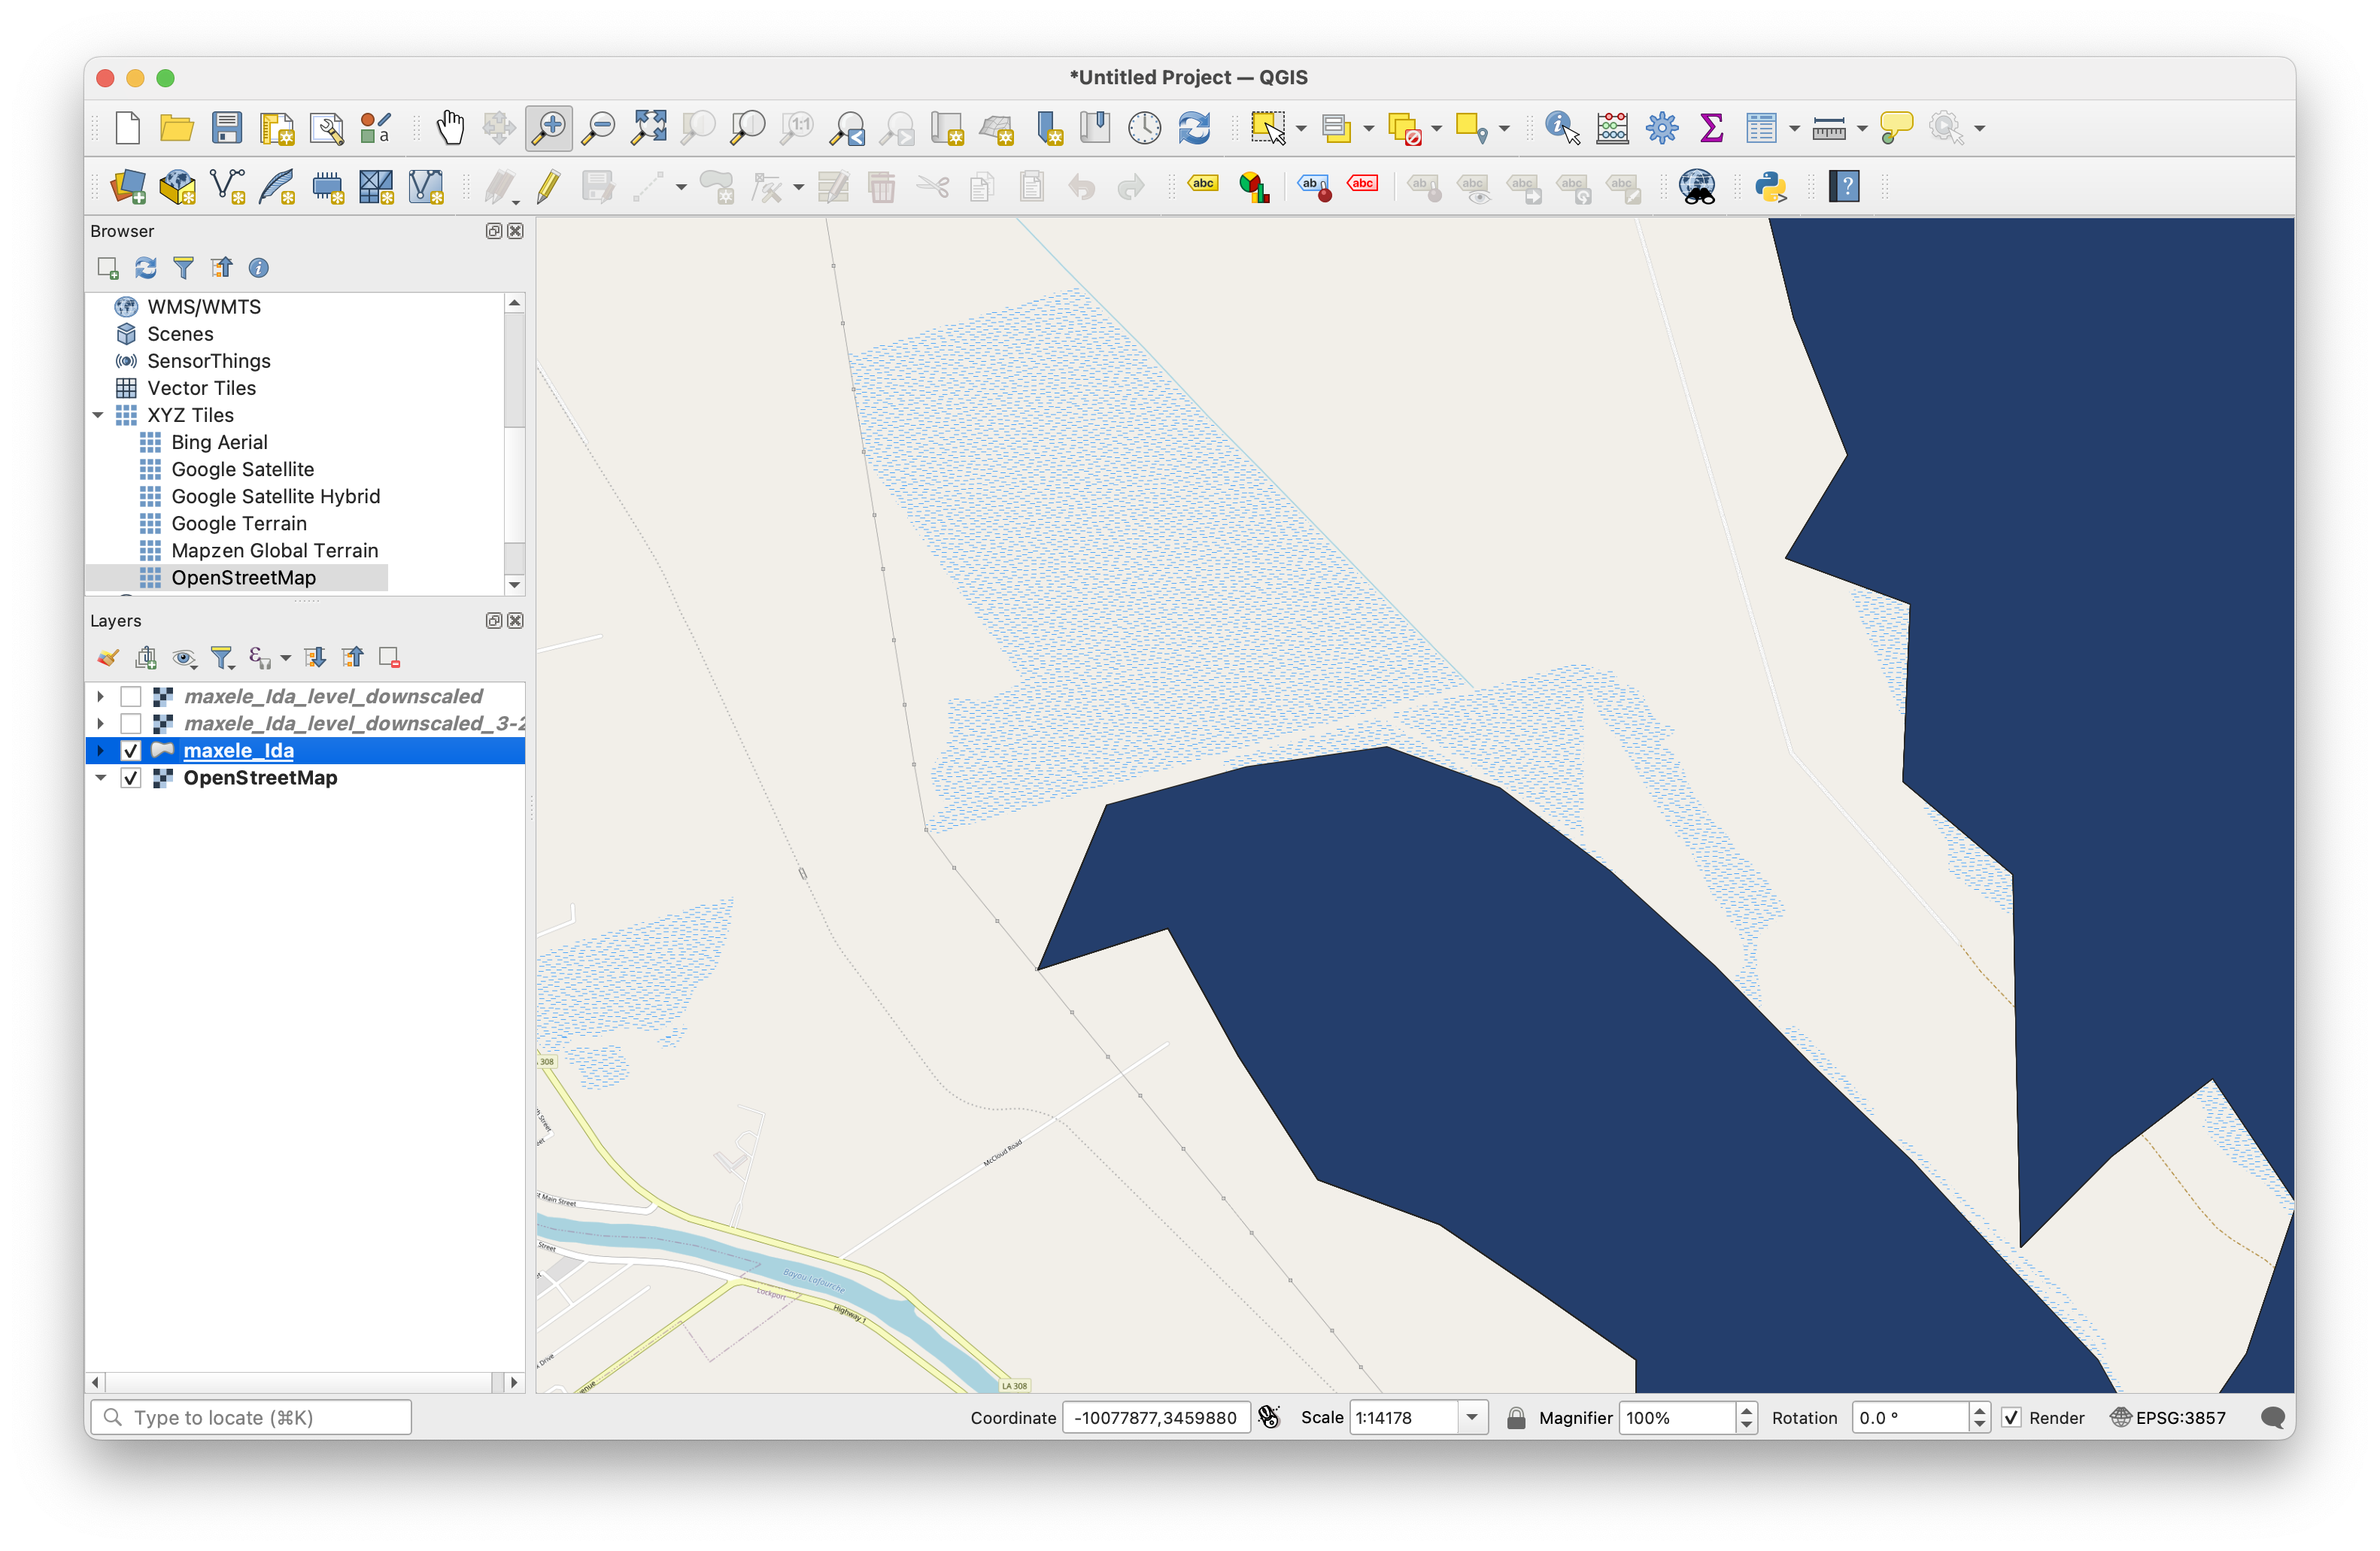

In [7]:
display(Image(filename=r'../../adds/imgs/example_3_4_a_ida_maxele.png', width = 712))

Without accounting for the levees (as in Examples 3-2 and 3-3), the flood surface is extrapolated across a levee and into the neighboring fields. The extrapolation distance is controlled by the local element sizes, so the water is extrapolated by a distance of one element (e.g. <code>repLenGrowing = 1.0</code>). But this extrapolation is not physical, because the water should be stopped by the levees.

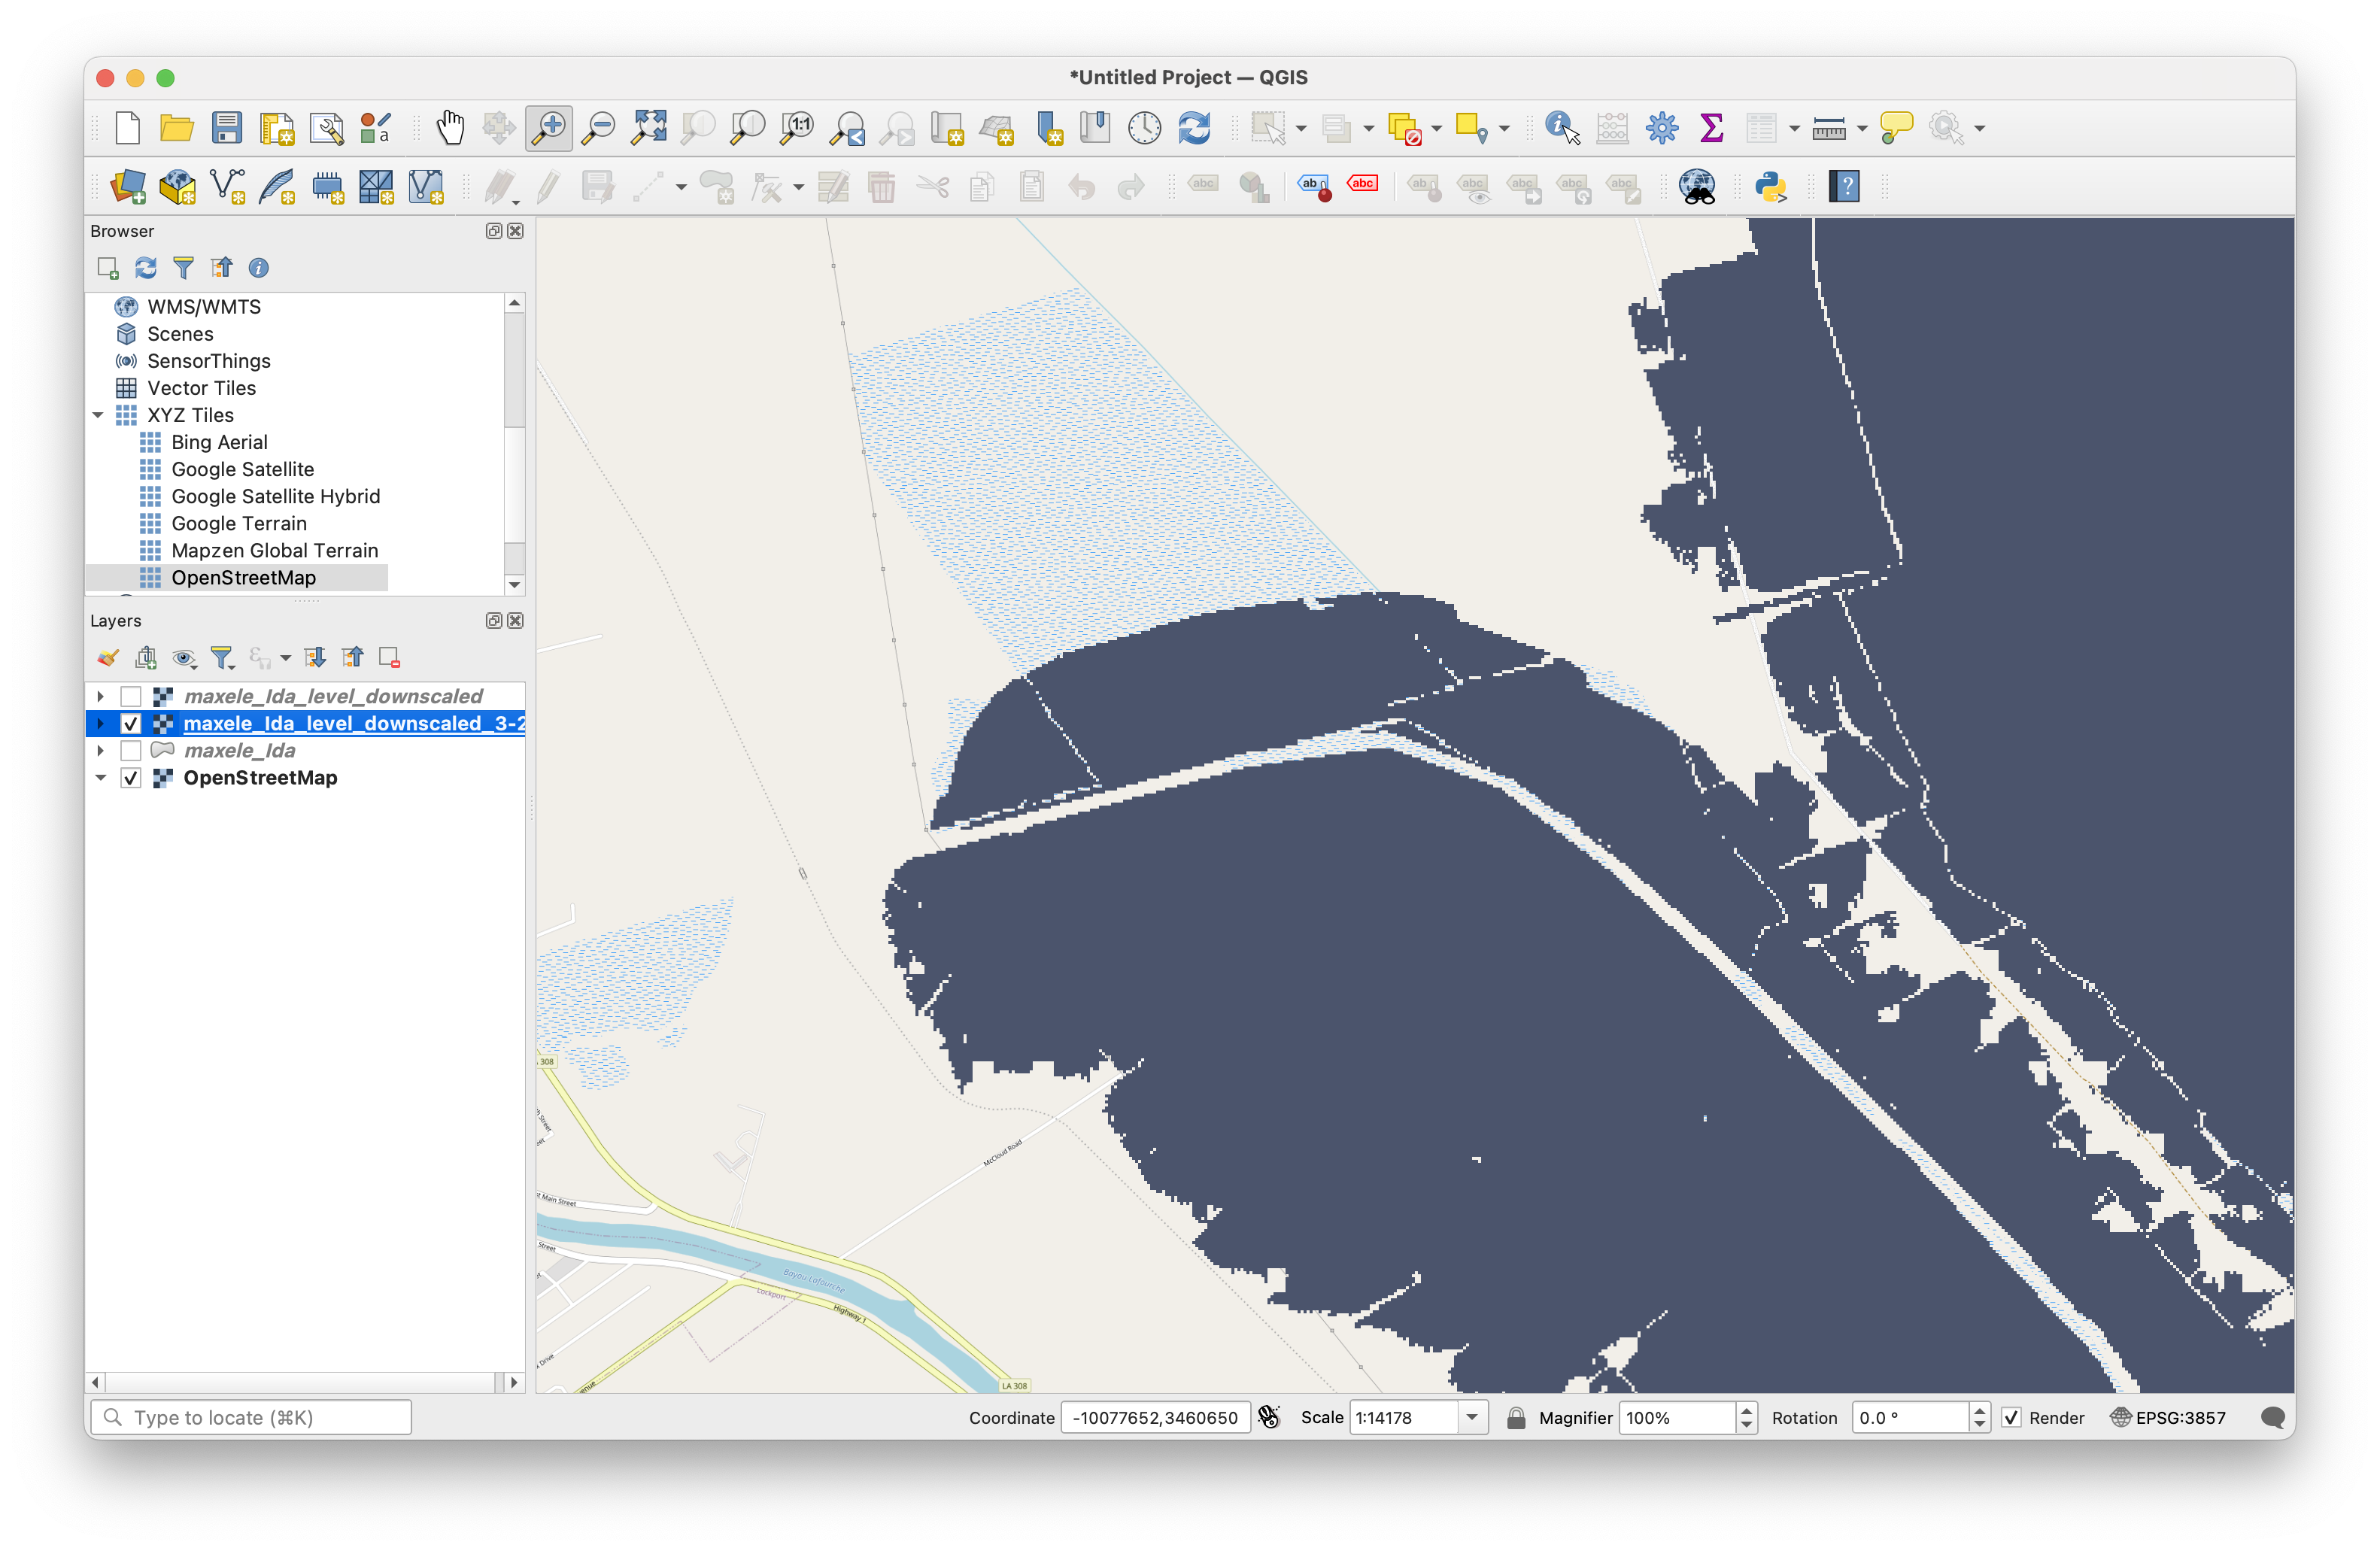

In [8]:
display(Image(filename=r'../../adds/imgs/example_3_4_b_ida_downscaled_no_levees.png', width = 712))

But when the downscaling accounts for the levees (as in this example), the extrapolation is prevented here.

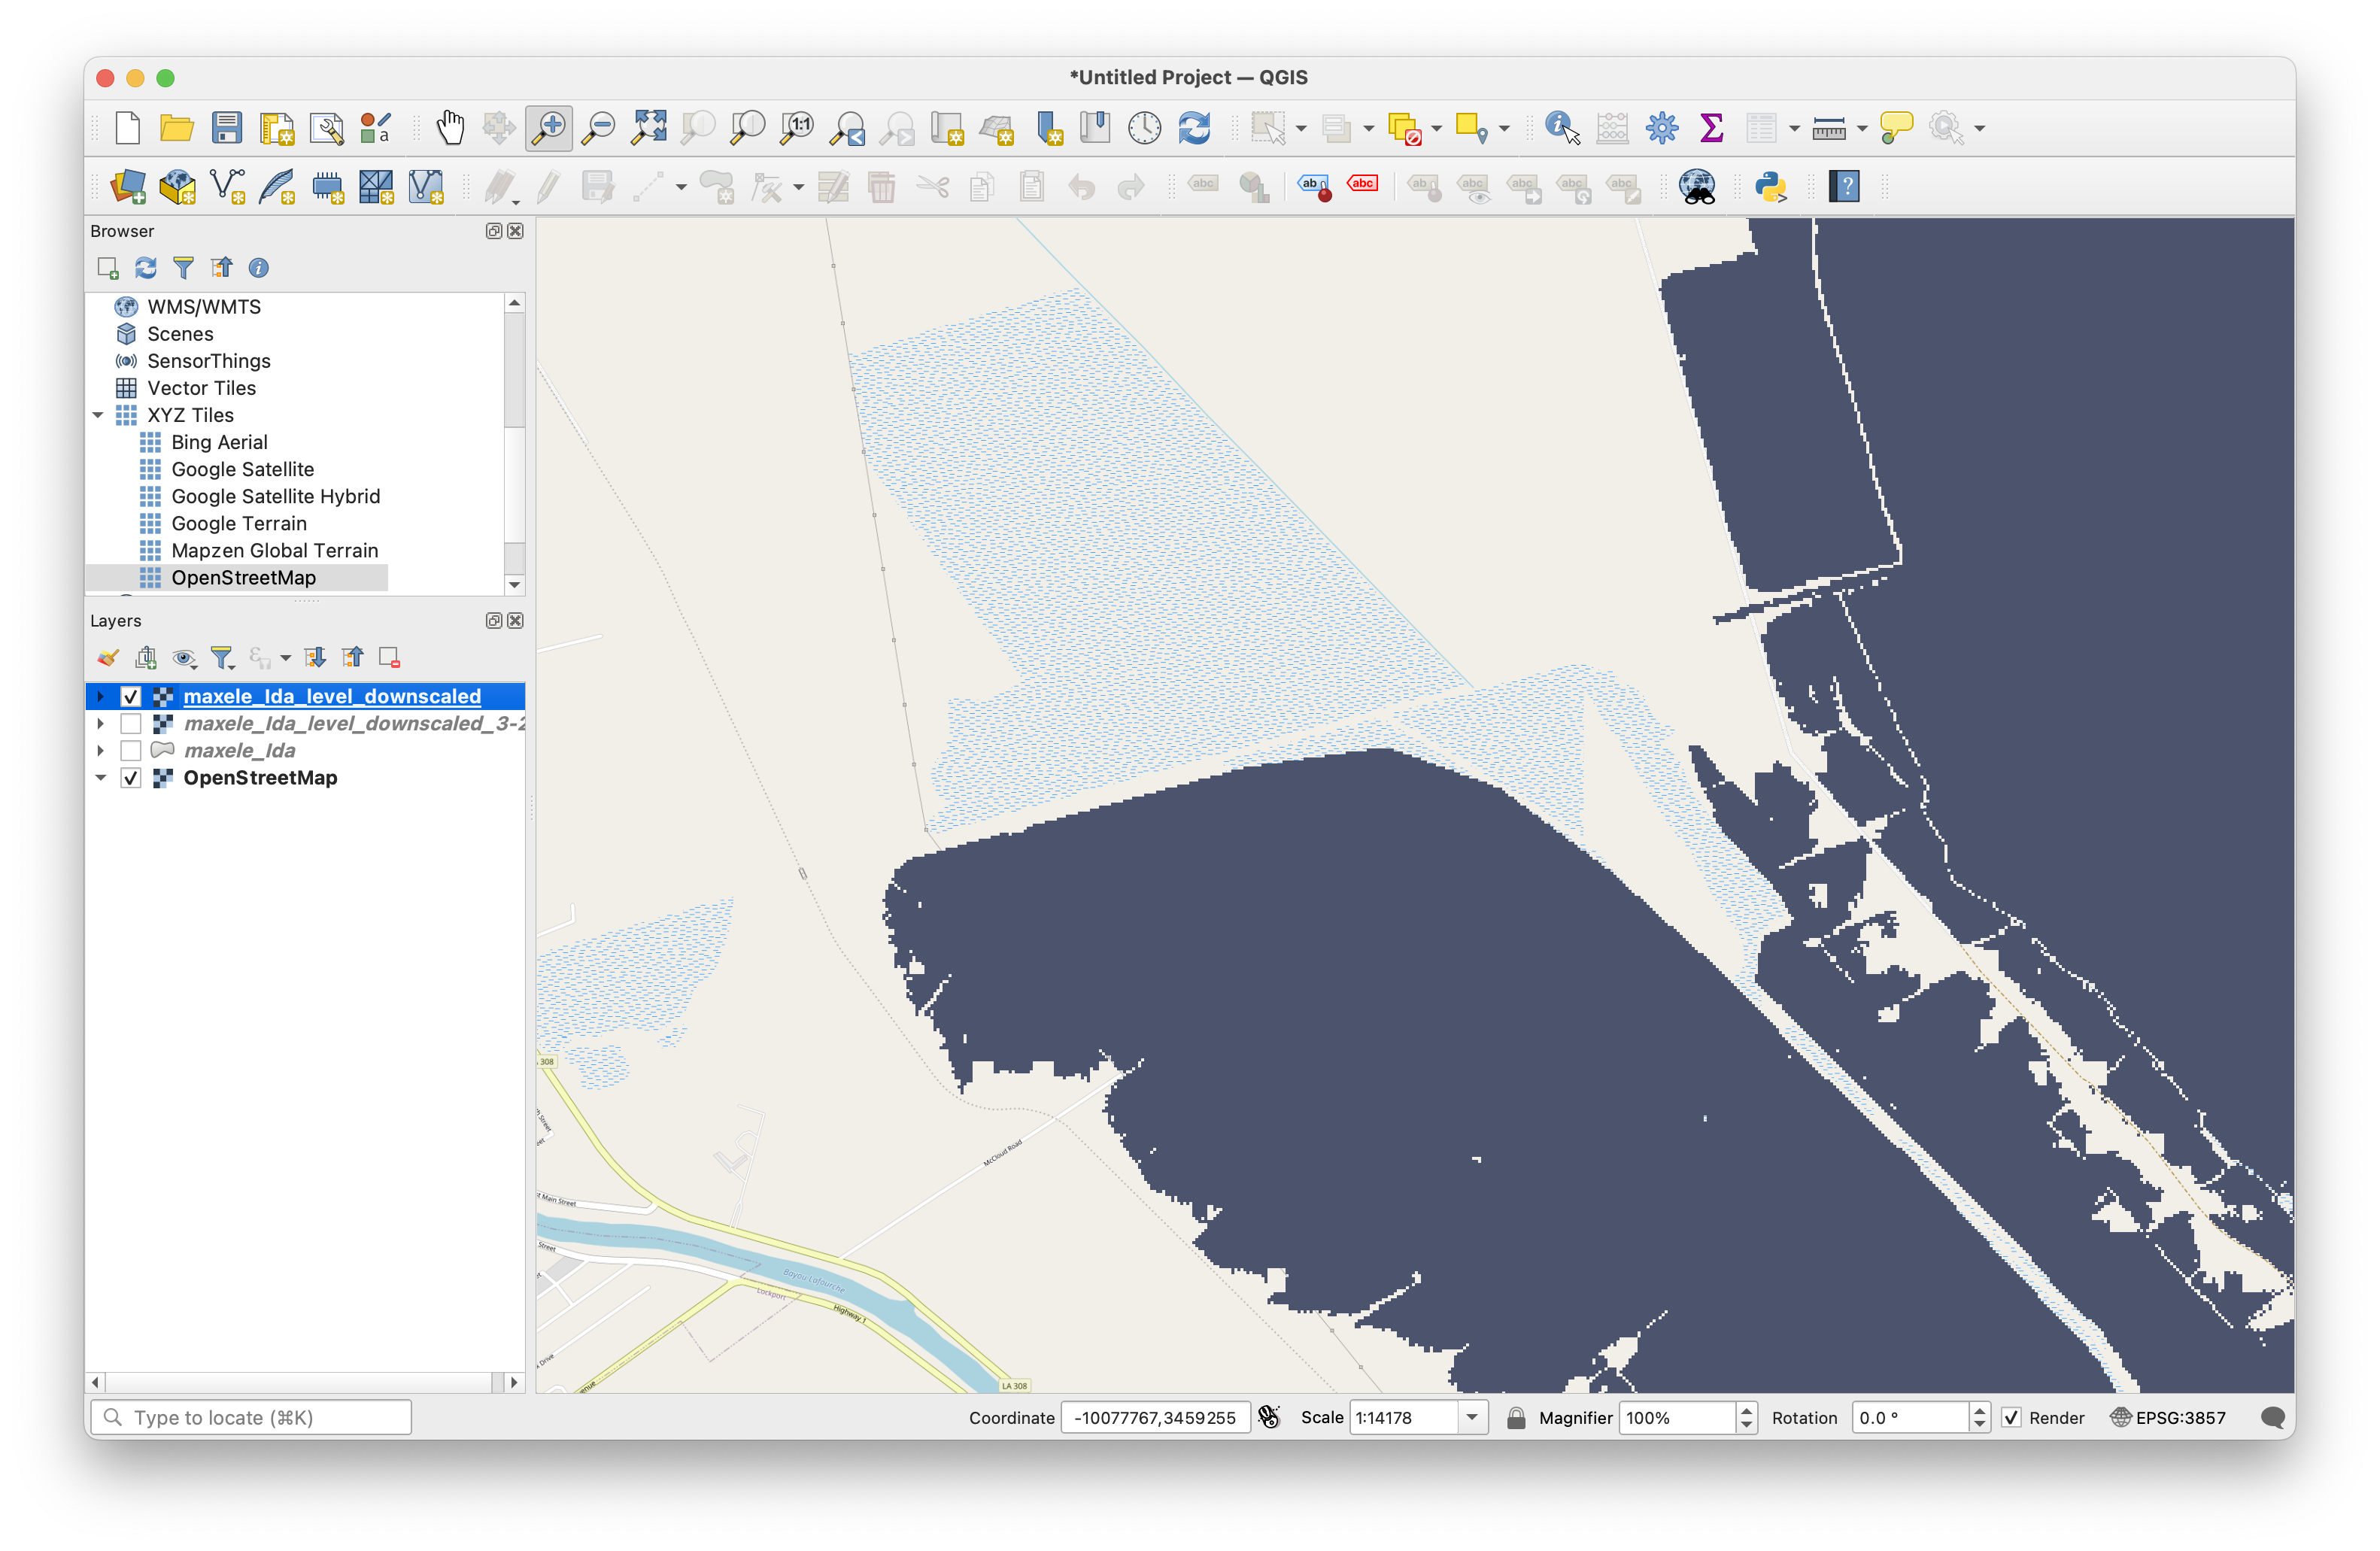

In [10]:
display(Image(filename=r'../../adds/imgs/example_3_4_c_ida_downscaled_levees.png', width = 712))

## Housekeeping

The following cell is optional. We include it to keep clean the repository -- it will delete the shapefile and geoTIFF that we just created. For most users, this cell is not necessary.

In [11]:
## clean
for f in glob.glob("CUDEM_merged_10m_crs3857_mesh*"):
    os.remove(f)

for f in glob.glob("downscaling_dem*"):
    os.remove(f)

for f in glob.glob("maxele_Ida*"):
    os.remove(f)

shutil.rmtree('grassLoc')

Good luck with Kalpana! See you in future examples!